In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import lmfit

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [3]:
df_gaussian = pd.read_csv('../results/Caltech101_Gaussian.csv', index_col=0)
df_resolution = pd.read_csv('../results/Caltech101_Resolution.csv', index_col=0)
classes = sorted(df_gaussian[df_gaussian['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']

In [5]:
dfs = [merf_df, larry_df, cite_df, cite_df]
metrics = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']
names = ['Spatial', 'Clonal', 'Protein', 'Cell Type']


# xs = np.logspace(-4, 3.5, 100)
# ys = 0.5*np.log2(1 + 1/xs)


# d = {
#     "Cell number": [],
#     "Imax" : [],
#     "x_bar" :[],
#     "Metric": []
# }

# for df, metric, name in zip(dfs[1:], metrics[1:], names[1:]):
#     for cell_number in df['Cell number'].unique():
#         N_cells = df[df['Cell number'] == cell_number]

#         for i, method in enumerate(['VAE']):
#             x_data = N_cells[N_cells['Method']== method]['UMI per cell']
#             ydata = N_cells[N_cells['Method']== method][metric]

#             model = Model(info_scaling)
#             params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
#             params['A'].min = 0  # set bounds
#             params['B'].min = 0

#             # fit model
#             result = model.fit(ydata, params, x=x_data)

#             if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

#                 if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
            

#                     x_bar = 1/result.params['A'].value

#                     x_hat = x_data / x_bar

#                     I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)
                    
#                     d['Metric'].append(name)    
#                     d['Cell number'].append(cell_number)
#                     d['Imax'].append(I_max)
#                     d['x_bar'].append(x_bar)

In [6]:
# df = pd.DataFrame(d)
# df

In [130]:
sub_df = cite_df[cite_df['Method'] == 'VAE']
x_data = sub_df['Cell number']
y_data = sub_df['Protein MI']
u_data = sub_df['UMI per cell']

In [155]:
def joint_scaling(x, u, I_inf, s, N0, K):
    def Imax(x, I_inf, s, N0):
        return I_inf - (x/1000)**s
    Im = Imax(x, I_inf, s, N0)
    return Im - 0.5 * np.log2((np.exp2(2*Im) -1 + K*u)/(K*u + 1 - np.exp2(-2*Im)))

# wrapper function for lmfit
def joint_scaling_lmfit(params, x, u):
    I_inf = params['I_inf']
    s = params['s']
    N0 = params['N0']
    K = params['K']
    return joint_scaling(x, u, I_inf, s, N0, K)

if np.any(np.isnan(y_data)):
    print("Warning: NaN values in y_data!")
if np.any(np.isnan(joint_scaling(x_data, u_data, 1, -1e-6, 10.0, 1e-3))):
    print("NaN detected in function output!")


# # define lmfit parameters
# params = lmfit.Parameters()
# params.add('I_inf', value=1.0, min=1e-6)
# params.add('s', value=-1.0, max=-1e-6)
# params.add('N0', value=100, min=10)
# params.add('K', value=1.0, min=1e-6)

# # create model and fit
# fit_result = lmfit.minimize(lambda p: joint_scaling_lmfit(p, x_data, u_data) - y_data, params)

# # print results
# lmfit.report_fit(fit_result)

In [156]:
model = lmfit.Model(joint_scaling, independent_vars=['x', 'u'])
params = model.make_params(I_inf=dict(value=5.0, min=1), 
                           s=dict(value=.1, min=1e-6), 
                           N0=dict(value=10**4, min=10), 
                           K=dict(value=1.0, min=1e-3))

result = model.fit(y_data, params, x=x_data, u=u_data)

In [152]:
print(result.fit_report())

[[Model]]
    Model(joint_scaling)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 100
    # variables        = 4
    chi-square         = 178.960012
    reduced chi-square = 1.86416679
    Akaike info crit   = 66.1992196
    Bayesian info crit = 76.6199003
    R-squared          = -3.2834e-07
##  Warning: uncertainties could not be estimated:
    s:      at boundary
    N0:     at initial value
[[Variables]]
    I_inf:  3.38055692 (init = 5)
    s:      1.0002e-06 (init = 0.1)
    N0:     10000.0000 (init = 10000)
    K:      843081.922 (init = 100)


In [147]:
x_fit = np.logspace(np.log10(np.min(x_data)), np.log10(np.max(x_data)), 100)
u_fit = np.logspace(np.log10(np.min(u_data)), np.log10(np.max(u_data)), 100)
# y_fit = joint_scaling(x_fit, u_fit, fit_result.params['I_inf'].value, 
#                       fit_result.params['s'].value, 
#                       fit_result.params['N0'].value, 
#                       fit_result.params['K'].value)

y_fit = model.eval(params=result.params, x=x_fit, u=u_fit)
y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, u=u_fit, sigma=2)
y_lower = -y_upper

In [148]:
res_df = pd.DataFrame({

    'Cell number': x_data,
    'UMI per cell': u_data,
    'Protein MI': y_data,
    'Joint scaling fit': y_fit,
    # 'Upper CI': y_upper,
    # 'Lower CI': y_lower

})

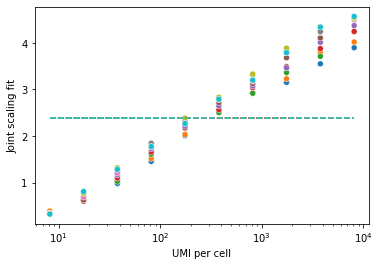

In [149]:
sns.lineplot(res_df, hue='Cell number', y='Joint scaling fit', x='UMI per cell', palette='tab10', legend=False, linestyle='--')
sns.scatterplot(res_df, hue='Cell number', y='Protein MI', x='UMI per cell', palette='tab10', legend=False)
plt.xscale('log')

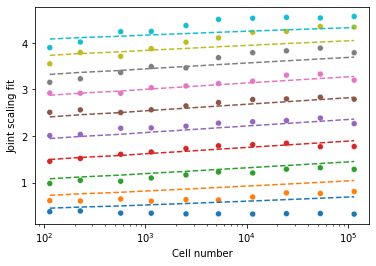

In [137]:
sns.lineplot(res_df, x='Cell number', y='Joint scaling fit', hue='UMI per cell', palette='tab10', legend=False, linestyle='--')
sns.scatterplot(res_df, x='Cell number', y='Protein MI', hue='UMI per cell', palette='tab10', legend=False)
plt.xscale('log')